# Анализ данных и предсказание показателей надежности с REST API к платформе AYATSK

Описание: это проект-демонстратор возможностей анализа и построения предсказательных моделей на основе статистики, собираемой в базе данных интегрированной логистической поддержки (ИЛП). Платформа AYATSK разработана АО НИЦ "Прикладная логистика" (https://cals.ru/) и позволяет получать из БД данные, используя REST API.
В данном проекте анализируются данные о наработке и отказах изделия-демонстратора и его составных частей. Средствами библиотеки "Reliability"(https://reliability.readthedocs.io/en/latest/index.html) исследуется распределение неисправностей и изменение показателей надежности во времени (reliability growth), 
выполняется обучение моделей (временные ряды) для прогнозирования количества отказов и выявления тех запасных частей, которые с большой вероятностью потребуются в будущем.
Все обозначения изделий и составных частей изменены на незначащие шифры, возможные совпадения случайны.

## Импорт библиотек

In [44]:
!pip install pandas==2.0.1 -q
!pip install scikit-learn==1.4 -q
!pip install lightgbm -q
!pip install Prophet -q
!pip install catboost -q
#Imports
import requests
import json
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
from reliability.Distributions import Weibull_Distribution
from reliability.Fitters import Fit_Weibull_3P, Fit_Weibull_2P, Fit_Weibull_Mixture
from reliability.Other_functions import make_right_censored_data, histogram
from reliability.Fitters import Fit_Everything
from reliability.Repairable_systems import reliability_growth, ROCOF
from reliability.Datasets import system_growth
from matplotlib import dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
# загружаем классы для подготовки данных
from sklearn.compose import ColumnTransformer
# загружаем pipeline, нужные модели и метрики
from numpy.random import RandomState
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from prophet import Prophet
from catboost import CatBoostRegressor, CatBoostClassifier

## Соединение с БД

In [45]:
#Разрыв соединения, созданного ранее
url_disconnect='http://localhost:7239/rest/disconnect'
disconnect_data = requests.get(url_disconnect)
print(disconnect_data)
# Соединение с БД
url_connect = 'http://localhost:7239/rest/connect/user=Administrator&db=aircraft_demo'
connect_data = requests.get(url_connect).json()
print(connect_data)
#Получение ключа сессии
print('session_key:',connect_data['session_key'])

<Response [200]>
{'_processingTime': '00:00:00.000', '_serverPort': '7239', '_serverVersion': '1.5.a.16840', '_applicationName': 'ILS Suite', '_serverVerDict': '1394', 'session_key': 'EDGCFGCBDECBCBGFNACFBDMGOCIHFAEAKELCLHKCHGEDDDGCAGHANEOBJADEEACEJFHDDHEDKHIABFBH', '_processingStart': ' 7.04.2024 11:46:28.924 '}
session_key: EDGCFGCBDECBCBGFNACFBDMGOCIHFAEAKELCLHKCHGEDDDGCAGHANEOBJADEEACEJFHDDHEDKHIABFBH


## Запрос основных данных об отказах

In [46]:
#Запрос основных данных об отказах
url_query=f'http://localhost:7239/rest&size=100000/load/t=e&ent=lss_refusal&all_attrs=true'
display('url_query:', url_query)
failures_json = requests.get(url_query, headers = {"X-APL-SessionKey": connect_data['session_key']}).json()
dfs = {}
dfs = pd.json_normalize(failures_json['instances'])
print(f'Всего строк: {len(dfs)}')
dfs.columns.values[0] = 'failure.id'
dfs.columns = dfs.columns.str.replace('attributes.', '', regex=False)
dfs['date_detected']= pd.to_datetime(dfs['date_detected'], errors='coerce')
#удалим служебные данные (доступ и тп)
dfs= dfs.drop(['type', 'access', 'planer.access', 'planer.type', 'system.access', 'system.type', 'item.access', 'item.type', 'consequence_lvl.access', 'stage_detection_lvl.access',\
       'refused_instance.access', 'refused_instance.type', 'reason.access', 'remedy.access', 'system_inst.access', 'speciality.access', 'detection_type.access', 'essence.access',\
       'consequence_lvl.type', 'stage_detection_lvl.type', 'reason.type','remedy.type','system_inst.type','speciality.type','detection_type.type','essence.type'], axis=1)
dfs.info()
dfs.head()

'url_query:'

'http://localhost:7239/rest&size=100000/load/t=e&ent=lss_refusal&all_attrs=true'

Всего строк: 1240
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1240 entries, 0 to 1239
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   failure.id              1240 non-null   int64         
 1   planer.id               1240 non-null   int64         
 2   system.id               1238 non-null   float64       
 3   item.id                 1230 non-null   float64       
 4   date_detected           1240 non-null   datetime64[ns]
 5   manifestation           1195 non-null   object        
 6   search_job_duration     1067 non-null   float64       
 7   search_job_labor        1068 non-null   float64       
 8   removal_job_labor       1016 non-null   float64       
 9   description             1195 non-null   object        
 10  id                      1240 non-null   object        
 11  consequence_lvl.id      1240 non-null   int64         
 12  mission_failure         1240 n

,failure.id,planer.id,system.id,item.id,...,type_for_system,led_to_incident,essence_descr,essence.id
0,17447,17432,10335,15905,...,DAMAGE,True,Обрыв звуконосителя,NaN
1,17464,17432,11335,15915,...,DAMAGE,True,Замыкание провода на корпус,NaN
2,17492,17473,10275,15950,...,DAMAGE,False,Нарушение устойчивости или управляемости ЛА по...,NaN
3,17497,17473,10275,15940,...,DAMAGE,False,Нарушение устойчивости или управляемости ЛА по...,NaN
4,17512,17502,10559,15965,...,DAMAGE,False,Отказ секции обогрева,NaN


In [47]:
#списки данных для доп обработки и загрузки из БД
component_column_names=['system.id', 'item.id']
component_instance_column_names=['planer.id', 'refused_instance.id', 'system_inst.id']
classifier_column_names=['reason.id', 'remedy.id', 'speciality.id', 'detection_type.id', 'essence.id']

In [48]:
#замена типов c float на int
dfs[component_column_names]= dfs[component_column_names].fillna(0)
dfs[component_column_names] =dfs[component_column_names].astype('int64', errors='ignore')
dfs[component_instance_column_names]= dfs[component_instance_column_names].fillna(0)
dfs[component_instance_column_names] =dfs[component_instance_column_names].astype('int64', errors='ignore')
dfs[classifier_column_names]= dfs[classifier_column_names].fillna(0)
dfs[classifier_column_names] =dfs[classifier_column_names].astype('int64', errors='ignore')
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1240 entries, 0 to 1239
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   failure.id              1240 non-null   int64         
 1   planer.id               1240 non-null   int64         
 2   system.id               1240 non-null   int64         
 3   item.id                 1240 non-null   int64         
 4   date_detected           1240 non-null   datetime64[ns]
 5   manifestation           1195 non-null   object        
 6   search_job_duration     1067 non-null   float64       
 7   search_job_labor        1068 non-null   float64       
 8   removal_job_labor       1016 non-null   float64       
 9   description             1195 non-null   object        
 10  id                      1240 non-null   object        
 11  consequence_lvl.id      1240 non-null   int64         
 12  mission_failure         1240 non-null   bool    

## Запрос дополнительных данных о составных частях изделия, которые отказывали в эксплуатации

In [49]:
#список компонентов для загрузки
len(dfs['item.id'].unique()>0)

570

In [50]:
#Запрос дополнительных данных о компонентах
url_query='http://localhost:7239/rest&size=100000/load'
for id in dfs['item.id'].unique():
    if id>0:
        url_query+= f'/t=a&id={id}'
url_query+='&all_attrs=true'
components_json = requests.get(url_query, headers = {"X-APL-SessionKey": connect_data['session_key']}).json()
components_data = {}
components_data = pd.json_normalize(components_json['instances'])
print(f'Всего строк: {len(components_data)}')
components_data.rename(columns = {'id': 'item.id', 'attributes.id': 'component_id'}, inplace = True)  
components_data.info()
components_data.head()

Всего строк: 569
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   item.id                            569 non-null    int64  
 1   type                               569 non-null    object 
 2   access                             569 non-null    object 
 3   component_id                       569 non-null    object 
 4   attributes.make_or_buy             169 non-null    object 
 5   attributes.part_of_la_form.access  169 non-null    object 
 6   attributes.part_of_la_form.id      169 non-null    float64
 7   attributes.part_of_la_form.type    169 non-null    object 
 8   attributes.class.access            1 non-null      object 
 9   attributes.class.id                1 non-null      float64
 10  attributes.class.type              1 non-null      object 
dtypes: float64(2), int64(1), object(8)
memory

,item.id,type,access,component_id,...,attributes.part_of_la_form.type,attributes.class.access,attributes.class.id,attributes.class.type
0,12504,apl_lss3_component,OWN,Бл-11А,...,NaN,NaN,NaN,NaN
1,12519,apl_lss3_component,OWN,Бл-12Б,...,NaN,NaN,NaN,NaN
2,12538,apl_lss3_component,OWN,Бл-345В,...,NaN,NaN,NaN,NaN
3,12553,apl_lss3_component,OWN,Бл-4-3342,...,NaN,NaN,NaN,NaN
4,12563,apl_lss3_component,OWN,Бл-46335Г,...,NaN,NaN,NaN,NaN


In [51]:
#объединяем таблицы
print(dfs.shape)
dfs= dfs.merge(components_data[['item.id', 'component_id']], on='item.id', how='left')
print(dfs.shape)
print(len(dfs['item.id'].unique()))
print(len(dfs['component_id'].unique()))
dfs.insert(4, 'component_id', dfs.pop('component_id'))
#добавляем столбец "год отказа"
dfs['failure_year']=dfs['date_detected'].dt.year
dfs.insert(6, 'failure_year', dfs.pop('failure_year'))
dfs.head(5)

(1240, 26)
(1240, 27)
570
570


,failure.id,planer.id,system.id,item.id,...,type_for_system,led_to_incident,essence_descr,essence.id
0,17447,17432,10335,15905,...,DAMAGE,True,Обрыв звуконосителя,0
1,17464,17432,11335,15915,...,DAMAGE,True,Замыкание провода на корпус,0
2,17492,17473,10275,15950,...,DAMAGE,False,Нарушение устойчивости или управляемости ЛА по...,0
3,17497,17473,10275,15940,...,DAMAGE,False,Нарушение устойчивости или управляемости ЛА по...,0
4,17512,17502,10559,15965,...,DAMAGE,False,Отказ секции обогрева,0


## Запрос данных о наработке

In [52]:
#Запрос корректировок наработки по отказу
url_query="http://localhost:7239/rest&size=100000/query&all_attrs=true"
corrects_json = requests.post(url=url_query, headers = {"X-APL-SessionKey": connect_data['session_key']},\
                              data="SELECT Ext1 FROM Ext0 {lss_refusal.id LIKE ''} Ext1 {ils_resource_correct(.type='set' AND .of_item!=#0 AND .basis IN #Ext0)} END_SELECT").json()
corrects_data = {}
corrects_data = pd.json_normalize(corrects_json['instances'])
corrects_data= corrects_data[['id', 'attributes.date_time', 'attributes.basis.id', 'attributes.of_item.id']]
print(f'Всего строк корректировки наработки: {len(corrects_data)}')
corrects_data.rename(columns = {'id': 'correct.id', 'attributes.basis.id': 'failure.id', 'attributes.of_item.id':'item.id', 'attributes.date_time': 'date_time'}, inplace = True)  
corrects_data.info()
corrects_data.head()

Всего строк корректировки наработки: 1677
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677 entries, 0 to 1676
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   correct.id  1677 non-null   int64 
 1   date_time   1677 non-null   object
 2   failure.id  1677 non-null   int64 
 3   item.id     1677 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 52.5+ KB


,correct.id,date_time,failure.id,item.id
0,26932,20210201000000,17447,17445
1,26936,20210501000000,17464,17432
2,26940,20210201000000,17447,17432
3,26944,20210702000000,17561,17569
4,26948,20210703000000,17615,17609


In [53]:
#Запрос значений  наработки 
query="SELECT Ext1 FROM Ext0 {ils_resource_correct.type='set'} Ext1 {ils_change_resource(.type='set' AND .basis->ils_resource_correct.# IN #Ext0)} END_SELECT"
operation_json = requests.post(url=url_query, headers = {"X-APL-SessionKey": connect_data['session_key']}, data=query).json()
#print(operation_json)
operation_data = {}
operation_data = pd.json_normalize(operation_json['instances'])
operation_data= operation_data[['id', 'attributes.basis.id', 'attributes.derived_resource_val', 'attributes.product_instance.id']]
print(f'Всего строк наработки: {len(operation_data)}')
operation_data.rename(columns = {'id': 'sys_id', 'attributes.basis.id': 'correct.id', 'attributes.product_instance.id':'product_instance.id', 'attributes.derived_resource_val': 'operation_on_failure'}, inplace = True)  
operation_data.info()
operation_data.head()

Всего строк наработки: 1676
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   sys_id                1676 non-null   int64
 1   correct.id            1676 non-null   int64
 2   operation_on_failure  1676 non-null   int64
 3   product_instance.id   1676 non-null   int64
dtypes: int64(4)
memory usage: 52.5 KB


,sys_id,correct.id,operation_on_failure,product_instance.id
0,26933,26932,3476,17445
1,26937,26936,4795,17432
2,26941,26940,4764,17432
3,26945,26944,3301,17569
4,26949,26948,2979,17609


In [54]:
len(operation_data['correct.id'].unique())

1676

In [55]:
#объединяем таблицы
print(corrects_data.shape)
print(operation_data.shape)
operation_data= operation_data.merge(corrects_data, on='correct.id', how='left')
operation_data= operation_data.drop(columns=['product_instance.id'])
print(operation_data.shape)
operation_data.sample(5)

(1677, 4)
(1676, 4)
(1676, 6)


,sys_id,correct.id,operation_on_failure,date_time,failure.id,item.id
1340,48774,48773,1091,19911201000000,43092,42428
1042,47773,47774,919,19880401000000,34009,33714
1250,48487,48486,785,19890101000000,41045,40914
594,28726,28725,721,20210623000000,22325,22322
1542,49486,49485,611,19851001000000,45539,45064


## Аналитика отказов составных частей изделия/отказов по времени

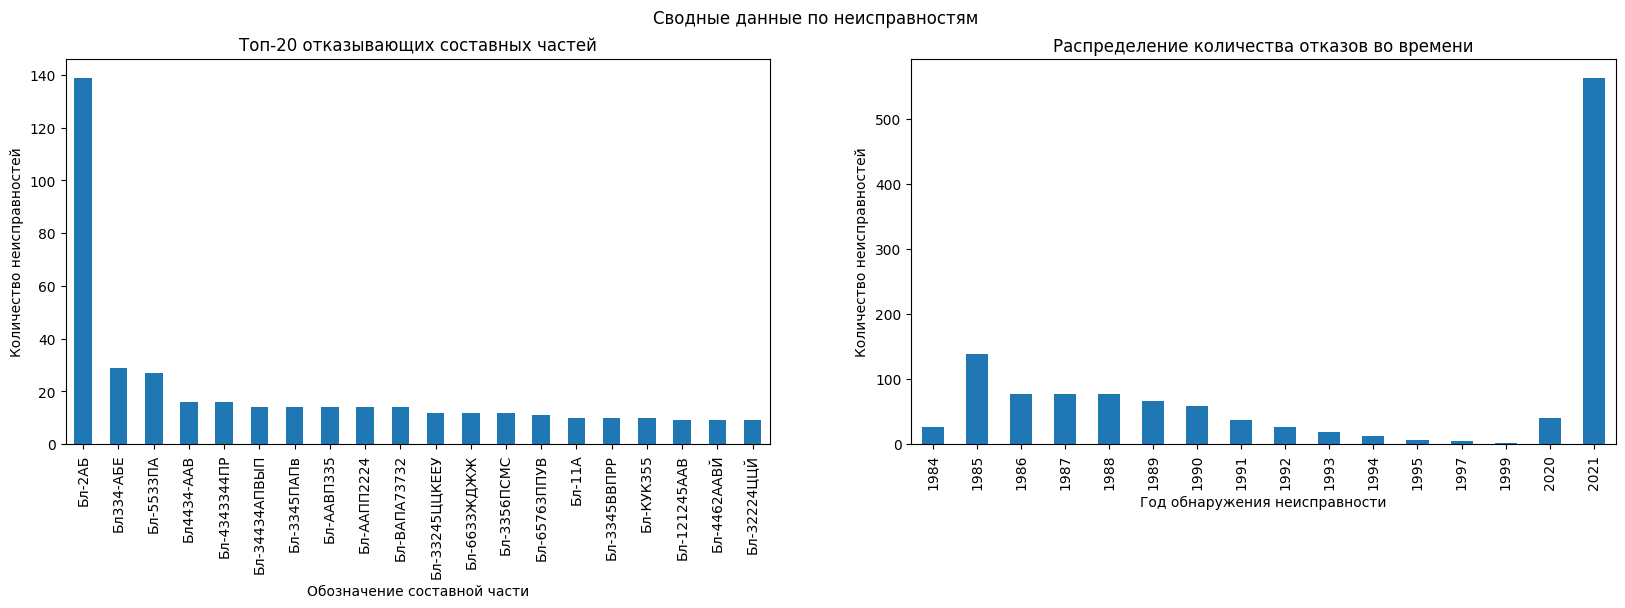

In [56]:
failure_components_top= dfs.groupby('component_id')['failure.id'].count().sort_values(ascending=False).head(20)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
fig.suptitle('Сводные данные по неисправностям')
failure_components_top.plot(
    ax=ax1,
    kind= 'bar',
    title='Топ-20 отказывающих составных частей',
    xlabel='Обозначение составной части',
    ylabel='Количество неисправностей'
)
dfs.groupby('failure_year')['failure.id'].count().plot(
    ax=ax2,
    kind= 'bar',
    title='Распределение количества отказов во времени',
    #bins=30
)
ax2.set_xlabel('Год обнаружения неисправности')
ax2.set_ylabel('Количество неисправностей')
plt.show()

## Аналитика времени поиска отказа

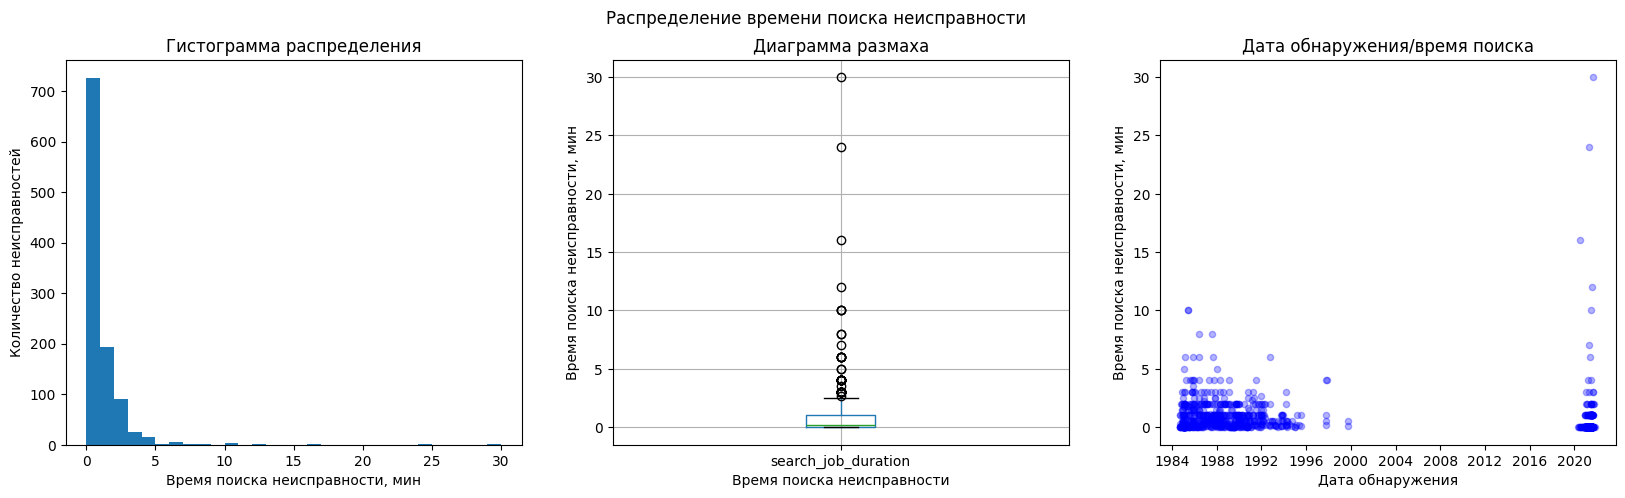

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('Распределение времени поиска неисправности')
dfs['search_job_duration'].plot(
    ax=ax1,
    kind= 'hist',
    title='Гистограмма распределения',
    bins=30
)
ax1.set_xlabel('Время поиска неисправности, мин')
ax1.set_ylabel('Количество неисправностей')
dfs.boxplot(
    ax= ax2, 
    column=['search_job_duration']
) 
ax2.set_title('Диаграмма размаха')
ax2.set_xlabel('Время поиска неисправности')
ax2.set_ylabel('Время поиска неисправности, мин')
dfs.plot(
    ax=ax3,
    x='date_detected', 
    y='search_job_duration',
    xlabel='Дата обнаружения',
    kind='scatter',
    ylabel='Время поиска неисправности, мин',
    title='Дата обнаружения/время поиска',
    alpha=0.3,
    color='blue'
)
plt.show()

## Аналитика трудоемкости устранения отказов

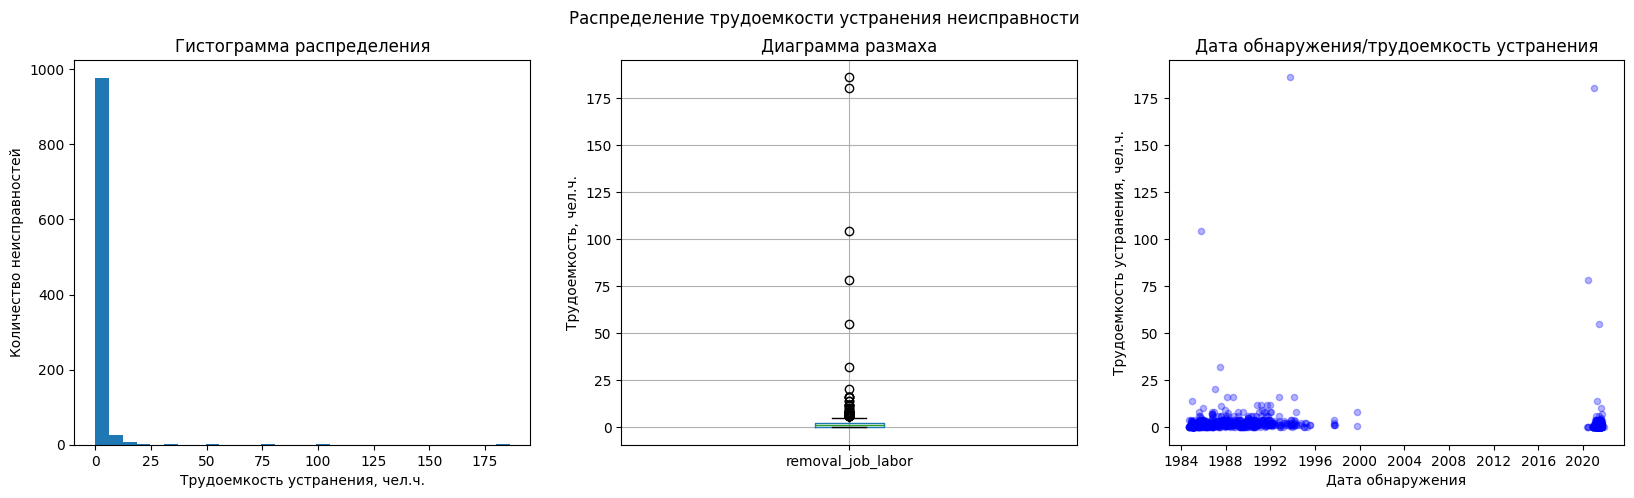

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('Распределение трудоемкости устранения неисправности')
dfs['removal_job_labor'].plot(
    ax=ax1,
    kind= 'hist',
    title='Гистограмма распределения',
    bins=30
)
ax1.set_xlabel('Трудоемкость устранения, чел.ч.')
ax1.set_ylabel('Количество неисправностей')
dfs.boxplot(
    ax= ax2, 
    column=['removal_job_labor']
) 
ax2.set_title('Диаграмма размаха')
ax2.set_ylabel('Трудоемкость, чел.ч.')
dfs.plot(
    ax=ax3,
    x='date_detected', 
    y='removal_job_labor',
    xlabel='Дата обнаружения',
    kind='scatter',
    ylabel='Трудоемкость устранения, чел.ч.',
    title='Дата обнаружения/трудоемкость устранения',
    alpha=0.3,
    color='blue'
)
plt.show()

## Анализ отказов в зависимости от наработки

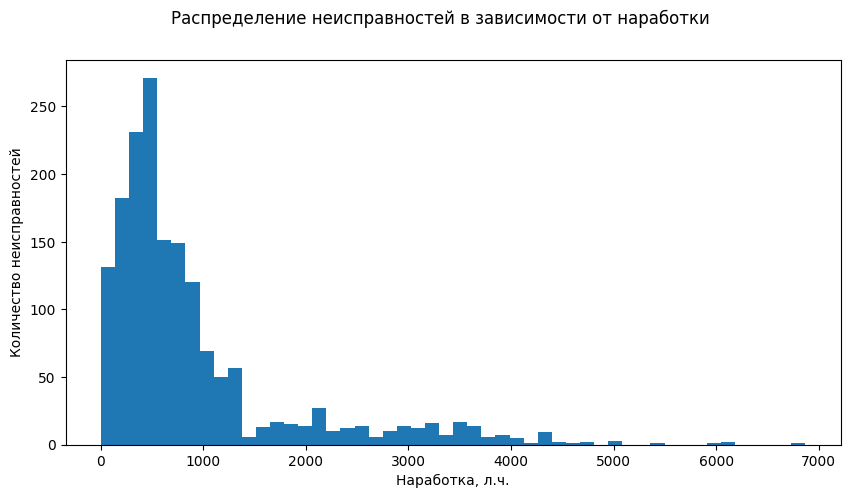

In [59]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))
fig.suptitle('Распределение неисправностей в зависимости от наработки')
operation_data['operation_on_failure'].plot(
    ax=ax1,
    kind= 'hist',
    bins=50
)
ax1.set_xlabel('Наработка, л.ч.')
ax1.set_ylabel('Количество неисправностей')
plt.show()

Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 1676/0 (0% right censored) 

   Distribution   Alpha    Beta   Gamma Alpha 1  Beta 1 Alpha 2  Beta 2 Proportion 1 DS      Mu   Sigma     Lambda  Log-likelihood    AICc     BIC      AD optimizer
Weibull_Mixture                         616.931 1.61842 2970.58 2.52632     0.828792                                      -12946.3 25902.6 25929.7 1.78039       TNC
 Loglogistic_2P   589.3 1.80895                                                                                           -13020.1 26044.1   26055 4.73856       TNC
 Loglogistic_3P   589.3 1.80895       0                                                                                   -13020.1 26046.1 26062.4 4.73856       TNC
   Lognormal_2P                                                                          6.3527 1.02184                   -13061.5 26126.9 26137.8 11.5871       TNC
   Lognormal_3P                       0                              

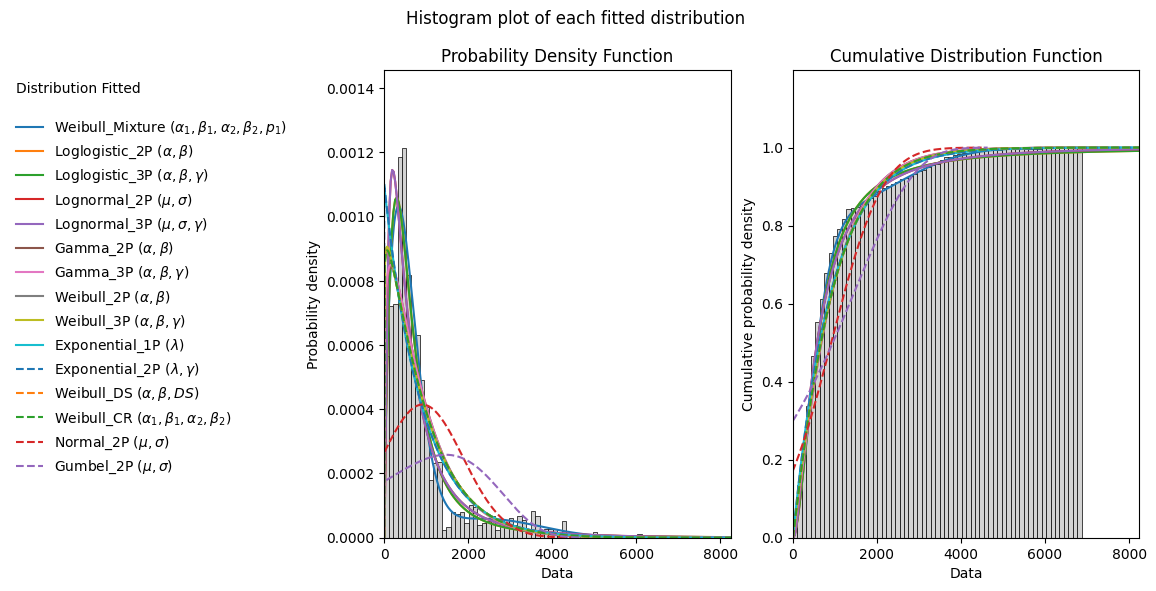

Наиболее подходящая функция распределения: Weibull_Mixture


In [60]:
threshold=10000
raw_data = operation_data['operation_on_failure'].to_numpy()   
data = make_right_censored_data(raw_data,threshold=threshold) #right censor some of the data
results = Fit_Everything(failures=data.failures, show_probability_plot= False, show_PP_plot=False, show_best_distribution_probability_plot =False)  # подбор разных моделей
print('Наиболее подходящая функция распределения:', results.best_distribution_name)

Fit_Weibull_2P параметры:
Alpha: 537.0774612433736 
Beta: 1.8689284506332482
Crow-AMSAA reliability growth model parameters:
Beta: 0.83584
Lambda: 2.19787
Growth rate: 0.16416
Demonstrated MTBF (cumulative): 1.4136
Demonstrated MTBF (instantaneous): 1.69122
Demonstrated failure intensity (cumulative): 0.70741
Demonstrated failure intensity (instantaneous): 0.59129
Time to reach target MTBF: 1749.18252

Results from ROCOF analysis:
Laplace test results: U = -9.898, z_crit = (-1.96,+1.96)
At 95% confidence level the ROCOF is IMPROVING. Assume NHPP.
ROCOF assuming NHPP has parameters: Beta_hat = 0.836 , Lambda_hat = 2.1979


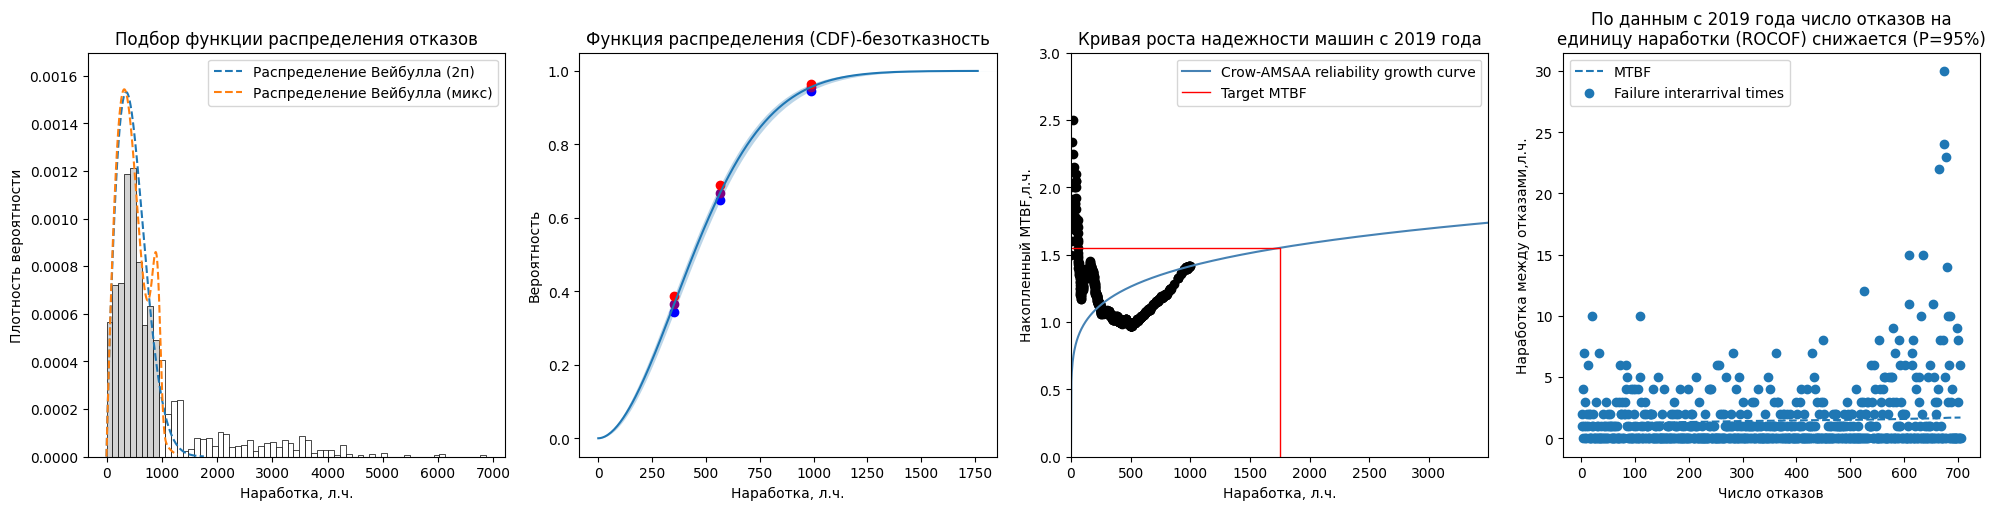

In [61]:
threshold=1000
raw_data = operation_data['operation_on_failure'].to_numpy()   
data = make_right_censored_data(raw_data,threshold=threshold) #right censor some of the data
wbf2 = Fit_Weibull_2P(failures=data.failures, show_probability_plot=False, print_results=False)  # fit the Weibull_3P distribution
print('Fit_Weibull_2P параметры:\nAlpha:', wbf2.alpha, '\nBeta:', wbf2.beta)
mixture = Fit_Weibull_Mixture(failures=data.failures, show_probability_plot=False, print_results=False)

plt.figure(figsize=(20,5))
plt.subplot(141)

histogram(raw_data,white_above=threshold) # generates the histogram using optimal bin width and shades the censored part as white
wbf2.distribution.PDF(label='Распределение Вейбулла (2п)', linestyle='--')  # plots to PDF of the fitted Weibull_2P
mixture.distribution.PDF(label='Распределение Вейбулла (микс)', linestyle='--')  # plots to PDF of the fitted Weibull_Mixture
plt.title('Подбор функции распределения отказов')
plt.ylabel('Плотность вероятности')
plt.xlabel('Наработка, л.ч.')
plt.legend()

CI_x = [operation_data['operation_on_failure'].quantile(0.25),operation_data['operation_on_failure'].quantile(0.5),operation_data['operation_on_failure'].quantile(0.75)]
CI_y = [0.25,0.5,0.75]

plt.subplot(142)
lower, point, upper = wbf2.distribution.CDF(CI_x=CI_x,CI_type='rel')
plt.scatter(CI_x,lower,color='blue')
plt.scatter(CI_x,point,color='purple')
plt.scatter(CI_x,upper,color='red')
plt.ylabel('Вероятность')
plt.xlabel('Наработка, л.ч.')
plt.title('Функция распределения (CDF)-безотказность')

plt.subplot(143)
rg_data= operation_data[operation_data['date_time']>'20190000000000']
raw_data = rg_data['operation_on_failure'].to_numpy()   
cdata = make_right_censored_data(raw_data,threshold=threshold) #right censor some of the data
reliability_growth(times=cdata.failures, model="Crow-AMSAA", target_MTBF=1.55)
#reliability_growth(times=system_growth().failures, model="Crow-AMSAA", target_MTBF=30)
plt.ylabel('Накопленный MTBF,л.ч.')
plt.xlabel('Наработка, л.ч.')
plt.title('Кривая роста надежности машин с 2019 года')

plt.subplot(144)
rocof_res=ROCOF(failure_times=cdata.failures)
plt.ylabel('Наработка между отказами,л.ч.')
plt.xlabel('Число отказов')
test_res='снижается'
if rocof_res.trend=='worsening':
    test_res= 'увеличивается'
elif rocof_res.trend=='constant':
    test_res= 'неизменно'
plt.title(f'По данным с 2019 года число отказов на\nединицу наработки (ROCOF) {test_res} (P=95%)')

plt.show()

## Анализ временного ряда для отказов за 2020-2021 год (период = 1 год)

In [62]:
#отберем данные за 21-22 год, сделаем дату отказа индексом
dfs_dt= dfs.copy()
dfs_dt=dfs_dt.set_index('date_detected')
sd = '2020-10-01'
ed = '2021-10-01' 
dates = pd.date_range(sd, ed)
dfs_dt =dfs_dt[dfs_dt.index.isin(dates)]
dfs_dt= dfs_dt.sort_index()
dfs_dt.info()
dfs_dt.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 592 entries, 2020-10-06 to 2021-09-29
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   failure.id              592 non-null    int64  
 1   planer.id               592 non-null    int64  
 2   system.id               592 non-null    int64  
 3   item.id                 592 non-null    int64  
 4   component_id            582 non-null    object 
 5   failure_year            592 non-null    int32  
 6   manifestation           547 non-null    object 
 7   search_job_duration     420 non-null    float64
 8   search_job_labor        421 non-null    float64
 9   removal_job_labor       374 non-null    float64
 10  description             547 non-null    object 
 11  id                      592 non-null    object 
 12  consequence_lvl.id      592 non-null    int64  
 13  mission_failure         592 non-null    bool   
 14  stage_detection_lvl.id 

,failure.id,planer.id,system.id,item.id,...,type_for_system,led_to_incident,essence_descr,essence.id
date_detected,,,,,,,,,
2020-10-06,26440,26381,11155,14139,...,DAMAGE,False,NaN,0
2020-10-20,26483,26468,11035,14164,...,DAMAGE,False,Обрыв,0
2020-10-20,17663,17651,11171,16040,...,DAMAGE,False,"Разрушение, излом",0
2020-10-27,26502,26468,11335,14184,...,DAMAGE,False,NaN,0
2020-10-27,17679,17666,11281,0,...,DAMAGE,False,"Порыв, порез, растрескивание изделий из резины",0


In [63]:
print('Временной ряд монотонно возрастает?', dfs_dt.index.is_monotonic_increasing)

Временной ряд монотонно возрастает? True


In [64]:
dfs_dt['failures_cnt']=1
#запомним количество отказов по составным частям в отдельном датафрейме

dfs_dt_products = dfs_dt[['component_id','failures_cnt']]

#после ресемплинга станем считать только ежедневное количество отказов 
dfs_dt = dfs_dt[['failures_cnt']]
print(dfs_dt.info())
dfs_dt.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 592 entries, 2020-10-06 to 2021-09-29
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   failures_cnt  592 non-null    int64
dtypes: int64(1)
memory usage: 9.2 KB
None


,failures_cnt
date_detected,
2020-10-06,1
2020-10-20,1
2020-10-20,1
2020-10-27,1
2020-10-27,1


Ресэмплируем до 1 дня 

In [65]:
dfs_dt = dfs_dt.resample('1D').sum()
print(dfs_dt.index.min()) 
print(dfs_dt.index.max()) 
dfs_dt.head(5)

2020-10-06 00:00:00
2021-09-29 00:00:00


,failures_cnt
date_detected,
2020-10-06,1
2020-10-07,0
2020-10-08,0
2020-10-09,0
2020-10-10,0


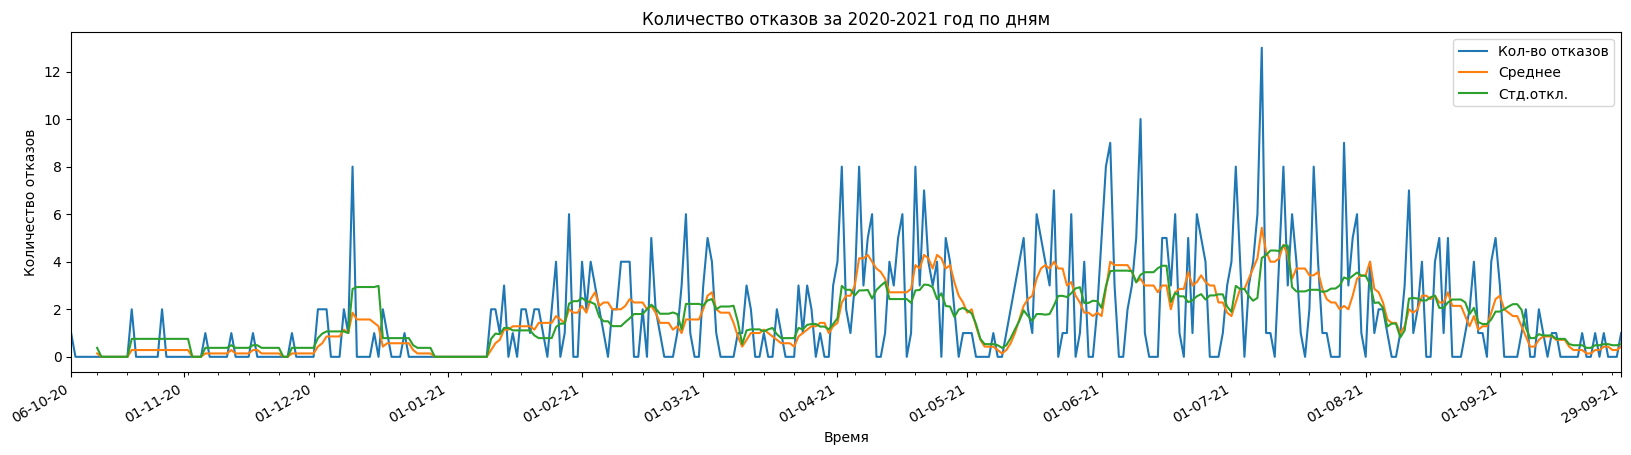

In [66]:
plt_data0= dfs_dt.copy()
plt_data0.columns= ['Кол-во отказов']
fig, ax = plt.subplots(figsize=(20,5))
plt_data0['Среднее']= plt_data0['Кол-во отказов'].rolling(7).mean()
plt_data0['Стд.откл.']= plt_data0['Кол-во отказов'].rolling(7).std()
plt_data0.plot(
    ax= ax,
    title='Количество отказов за 2020-2021 год по дням',
    xlabel='Время',
    ylabel='Количество отказов'
)
xformatter = mdates.DateFormatter('%d-%m-%y')
ax.xaxis.set_major_formatter(xformatter)
fig.autofmt_xdate()
plt.show()

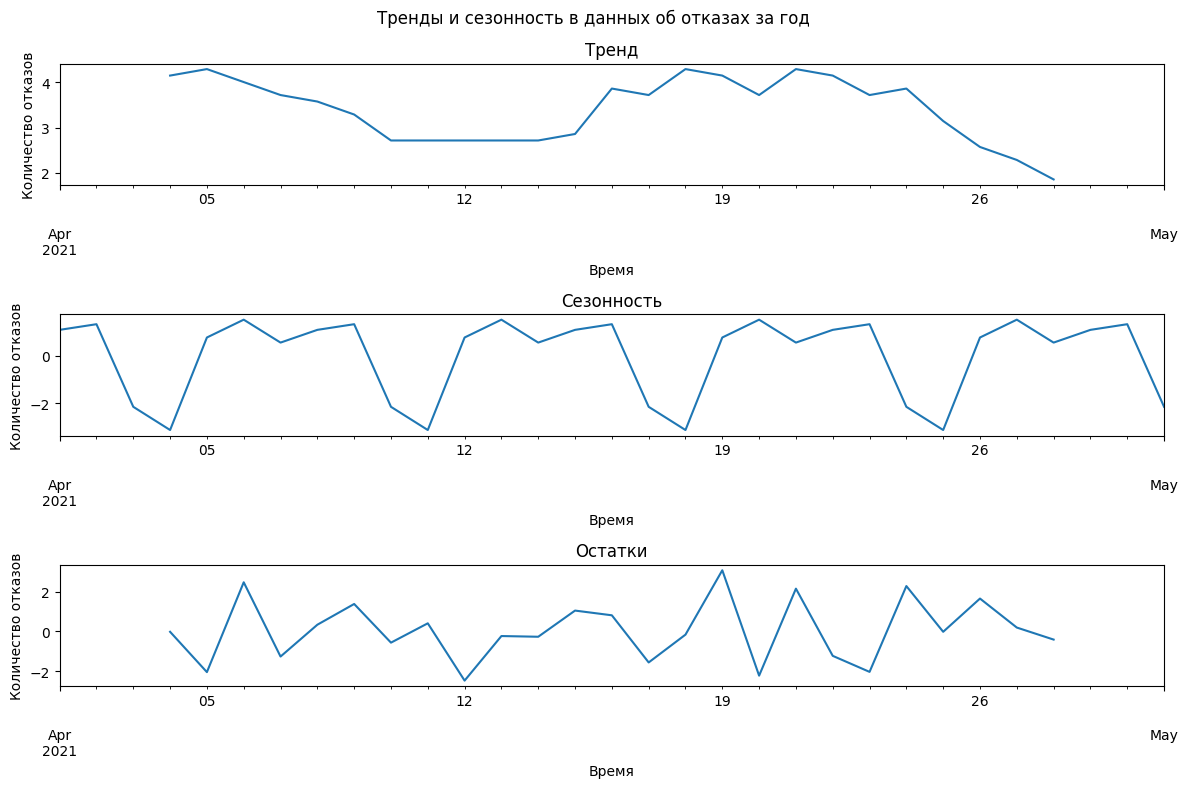

In [67]:
#разложим на составляющие (тренд, сезонность) данные за апрель 2021 года
plt_data= dfs_dt['2021-04-01':'2021-05-01'].copy()
decomposed = seasonal_decompose(plt_data) 
plt.figure(figsize=(12, 8))
plt.suptitle('Тренды и сезонность в данных об отказах за год')
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Время')
plt.ylabel('Количество отказов')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Время')
plt.ylabel('Количество отказов')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.xlabel('Время')
plt.ylabel('Количество отказов')
plt.title('Остатки')
plt.tight_layout()

Похоже, что есть сезонность, связанная со снижением количества отказов (скорее всего из-за меньшего количества полетов) в выходные

## Обучение модели предсказания количества отказов

In [68]:
#создаем дополнительные признаки
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    data['day'] = data.index.day
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['failures_cnt'].shift(lag)

    data['rolling_mean'] = data['failures_cnt'].shift().rolling(rolling_mean_size).mean()

make_features(dfs_dt, 2, 7)
dfs_dt.head(10)

,failures_cnt,dayofweek,month,day,lag_1,lag_2,rolling_mean
date_detected,,,,,,,
2020-10-06,1,1,10,6,NaN,NaN,NaN
2020-10-07,0,2,10,7,1,NaN,NaN
2020-10-08,0,3,10,8,0,1,NaN
2020-10-09,0,4,10,9,0,0,NaN
2020-10-10,0,5,10,10,0,0,NaN
2020-10-11,0,6,10,11,0,0,NaN
2020-10-12,0,0,10,12,0,0,NaN
2020-10-13,0,1,10,13,0,0,0.142857
2020-10-14,0,2,10,14,0,0,0


In [69]:
#Разделим выборку на тренировочную и тестовую
train, test = train_test_split(dfs_dt, shuffle=False, test_size=0.1)
train = train.dropna()
X_train = train.drop(columns=['failures_cnt'], axis=1)
y_train = train['failures_cnt']
X_test = test.drop(columns=['failures_cnt'], axis=1)
y_test = test['failures_cnt']

In [70]:
#Создаём общий пайплайн для подготовки данных
num_columns= X_train.columns
num_columns

Index(['dayofweek', 'month', 'day', 'lag_1', 'lag_2', 'rolling_mean'], dtype='object')

In [71]:
data_preprocessor = ColumnTransformer(
    [('num', ['passthrough'], num_columns)
    ], 
    remainder='passthrough'
)
RANDOM_STATE = 77
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [72]:
RANDOM_STATE = 77
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,8),
        'models__min_samples_leaf': range(2,8),
        'models__min_samples_split': range(2,8),
        'preprocessor__num': ['passthrough'] 
    },
    #словарь для модели LGBMRegressor
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,8),
        'models__num_leaves': range(2,8),
        'preprocessor__num': ['passthrough']
    },
    #словарь для модели CatBoostRegressor
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE, allow_writing_files=False, verbose=False)],
        'models__max_depth': range(2,8),
        'preprocessor__num': ['passthrough'] 
    }
]


создаем параметры для кросс-валидации временного ряда

In [73]:
tscv = TimeSeriesSplit(n_splits=7)

In [74]:
cv_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    cv= tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_iter=100,
    n_jobs=-1,
    error_score='raise',
    verbose=False
)
cv_search.fit(X_train, y_train)
print('Лучшая модель:\n\n', cv_search.best_estimator_)
print ('Параметры лучшей модели:', cv_search.best_params_)
print ('Метрика RMSE лучшей модели на тренировочной выборке:', round(-1*cv_search.best_score_,2))

Лучшая модель:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  Index(['dayofweek', 'month', 'day', 'lag_1', 'lag_2', 'rolling_mean'], dtype='object'))])),
                ('models',
                 DecisionTreeRegressor(max_depth=3, min_samples_leaf=6,
                                       min_samples_split=7, random_state=77))])
Параметры лучшей модели: {'preprocessor__num': 'passthrough', 'models__min_samples_split': 7, 'models__min_samples_leaf': 6, 'models__max_depth': 3, 'models': DecisionTreeRegressor(random_state=77)}
Метрика RMSE лучшей модели на тренировочной выборке: 1.94


Предсказание и расчет метрики на тестовой выборке

In [75]:
y_pred= cv_search.best_estimator_.predict(X_test)
RMSE = root_mean_squared_error(y_test.tolist(), y_pred) 
print(f'Метрика RMSE лучшей модели на тестовой выборке: {round(RMSE,2)}')

Метрика RMSE лучшей модели на тестовой выборке: 1.31


Построим графики для сравнения тестовой выборки и предсказаний

In [76]:
plt_data2 = pd.concat([y_test, pd.DataFrame(y_pred, columns=['предсказанное кол-во отказов'], index= X_test.index)], axis=1)
plt_data2.columns=['реальное кол-во отказов', 'предсказанное кол-во отказов']
plt_data2.head()

,реальное кол-во отказов,предсказанное кол-во отказов
date_detected,,
2021-08-25,2,2.40244
2021-08-26,4,2.40244
2021-08-27,1,4.54545
2021-08-28,1,0.348837
2021-08-29,0,0.348837


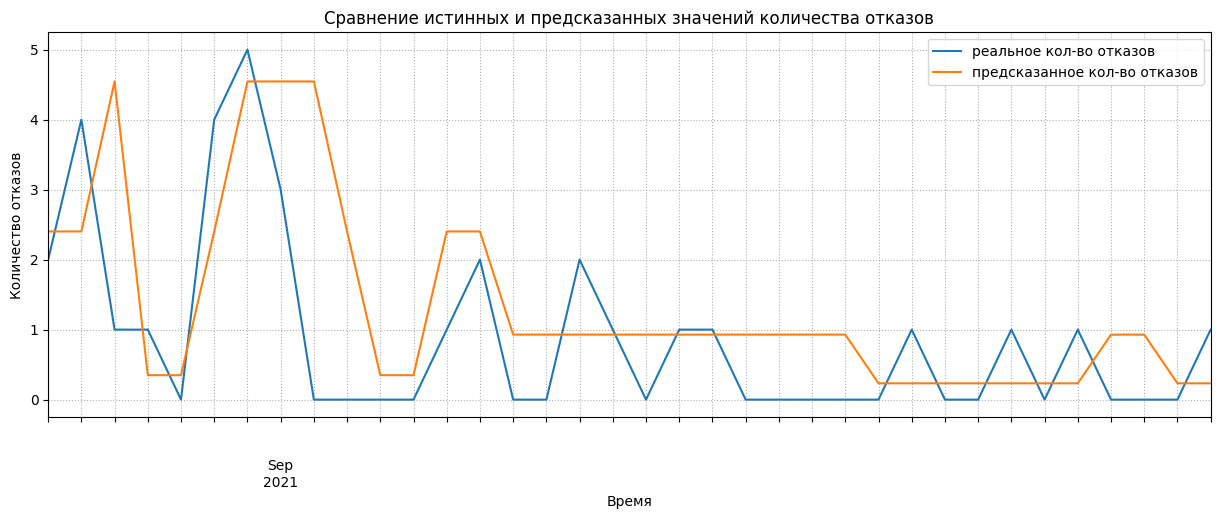

In [77]:
fig, ax = plt.subplots(figsize=(15,5))
plt_data2.plot(
    ax= ax,
    title='Сравнение истинных и предсказанных значений количества отказов',
    xlabel='Время',
    ylabel='Количество отказов'
)
ax.set_xticks(plt_data2.index)
plt.grid(True, linestyle = ':')
plt.show()

## Обучение еще одной модели для предсказания количества отказов по временному ряду (Prophet)

In [78]:
#еще одна модель, специльно заточенная для временных рядов Prophet
train2, test2 = train_test_split(dfs_dt, shuffle=False, test_size=0.1)
train2['ds']= train2.index
train2['y']= train2['failures_cnt']
train2.head()

,failures_cnt,dayofweek,month,day,lag_1,lag_2,rolling_mean,ds,y
date_detected,,,,,,,,,
2020-10-06,1,1,10,6,NaN,NaN,NaN,2020-10-06,1
2020-10-07,0,2,10,7,1,NaN,NaN,2020-10-07,0
2020-10-08,0,3,10,8,0,1,NaN,2020-10-08,0
2020-10-09,0,4,10,9,0,0,NaN,2020-10-09,0
2020-10-10,0,5,10,10,0,0,NaN,2020-10-10,0


In [79]:
m = Prophet()
m.fit(train2)

11:46:52 - cmdstanpy - INFO - Chain [1] start processing
11:46:52 - cmdstanpy - INFO - Chain [1] done processing


In [80]:
#forecast = m.predict(future)
test2['ds']= test2.index
forecast = m.predict(test2)
forecast= forecast.set_index(test2.index)
forecast['y']= test2['failures_cnt']
RMSE = root_mean_squared_error(forecast['y'], forecast['yhat']) 
print(f'Метрика RMSE на тестовой выборке: {round(RMSE,2)}')
forecast.tail()

Метрика RMSE на тестовой выборке: 2.94


,ds,trend,yhat_lower,yhat_upper,...,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
date_detected,,,,,,,,,
2021-09-25,2021-09-25,3.54549,-0.125952,4.77484,...,0,0,2.33041,1
2021-09-26,2021-09-26,3.55413,-0.542759,4.4264,...,0,0,1.93779,0
2021-09-27,2021-09-27,3.56278,0.765077,5.80129,...,0,0,3.24115,0
2021-09-28,2021-09-28,3.57142,1.97939,6.70751,...,0,0,4.33088,0
2021-09-29,2021-09-29,3.58006,1.8537,6.75113,...,0,0,4.24288,1


In [81]:
plt_data3 = forecast[['y','yhat']]
plt_data3.columns=['реальное кол-во отказов', 'предсказанное кол-во отказов']
plt_data3.head()

,реальное кол-во отказов,предсказанное кол-во отказов
date_detected,,
2021-08-25,2,3.9404
2021-08-26,4,4.39574
2021-08-27,1,3.91613
2021-08-28,1,2.08844
2021-08-29,0,1.69581


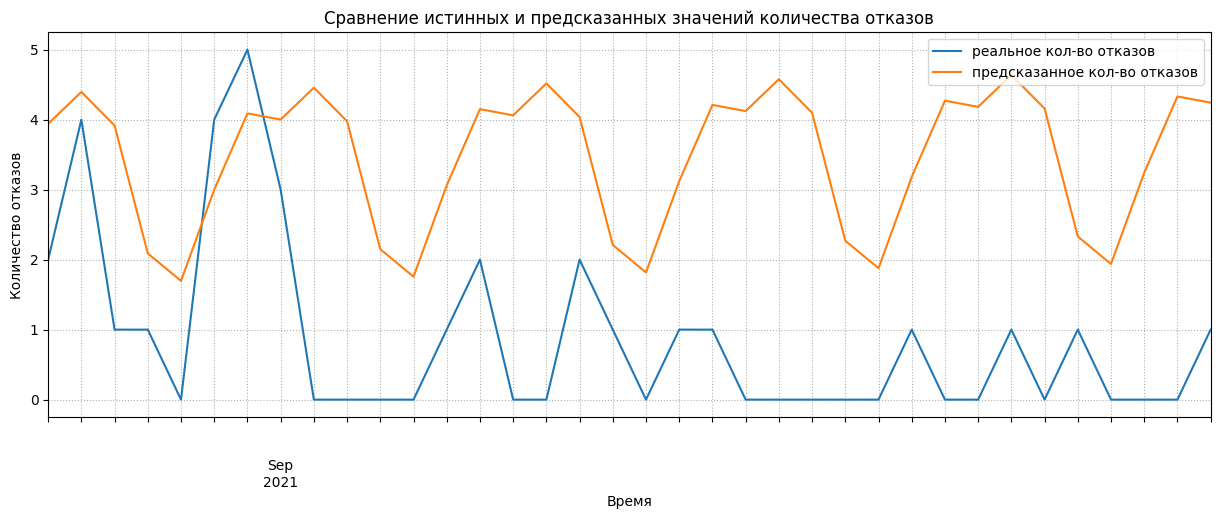

In [82]:
fig, ax = plt.subplots(figsize=(15,5))
plt_data3.plot(
    ax= ax,
    title='Сравнение истинных и предсказанных значений количества отказов',
    xlabel='Время',
    ylabel='Количество отказов'
)
ax.set_xticks(plt_data3.index)
plt.grid(True, linestyle = ':')
plt.show()

## Предскажем отказы составных частей определенных типов на основе данных за 2020-2021 год

In [83]:
print(dfs_dt_products.info())
dfs_dt_products.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 592 entries, 2020-10-06 to 2021-09-29
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   component_id  582 non-null    object
 1   failures_cnt  592 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ KB
None


,component_id,failures_cnt
date_detected,,
2020-10-06,Роллс-Ройс,1
2020-10-20,ВтНВ,1
2020-10-20,ТВ23-117,1
2020-10-27,ВР226,1
2020-10-27,NaN,1


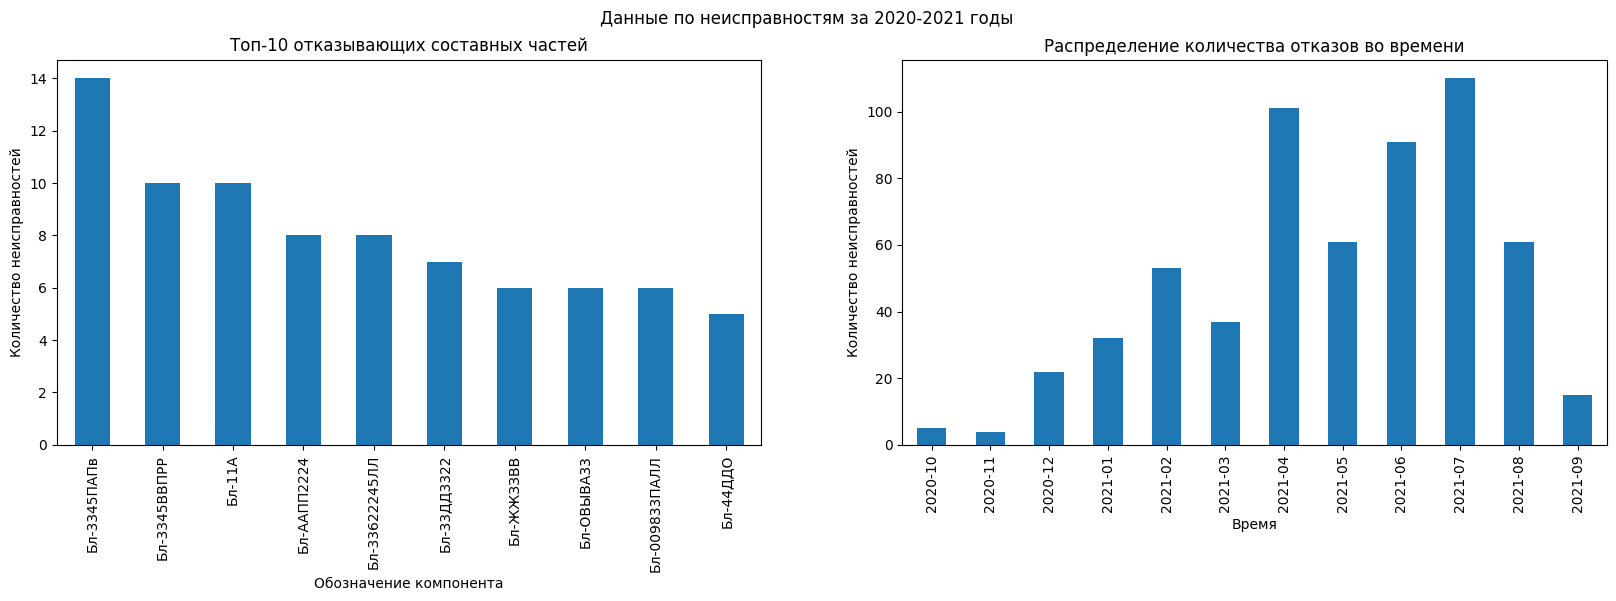

In [84]:
failure_components_top= dfs_dt_products.groupby('component_id')['failures_cnt'].sum().sort_values(ascending=False).head(10)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
fig.suptitle('Данные по неисправностям за 2020-2021 годы')
failure_components_top.plot(
    ax=ax1,
    kind= 'bar',
    title='Топ-10 отказывающих составных частей',
    xlabel='Обозначение компонента',
    ylabel='Количество неисправностей'
)
plt_data3= dfs_dt_products.copy()
plt_data3['failure_month']= plt_data3.index.to_period('M')
plt_data3.groupby('failure_month')['failures_cnt'].sum().plot(
    ax=ax2,
    kind= 'bar',
    title='Распределение количества отказов во времени',
    xlabel='Время',
    ylabel='Количество неисправностей'
)
plt.show()

In [85]:
#массив временных рядов по 5 наиболее отказывающим компонентам для моделирования с ресемплингом по дням
dfs_dt_prd= [] 
def log_bool(failure_cnt_arr):
    result=0
    if np.any(np.array(failure_cnt_arr)>0):
        result= 1
    return result

features_train0, features_valid0, target_train0, target_valid0 = train_test_split(dfs_dt_products, dfs_dt_products, shuffle=False, test_size=0.1)
df_predicts_prd= pd.DataFrame(index= features_valid0.index)
df_predicts_prd = df_predicts_prd.resample('1D').apply(log_bool)
for comp_id in failure_components_top.index:
    dfs_top_comp= dfs_dt_products[dfs_dt_products['component_id']==comp_id].copy()
    dfs_top_comp = dfs_top_comp[['failures_cnt']]
    dfs_top_comp = dfs_top_comp.resample('1D').apply(log_bool)
    
    #создадим признаки на основе даты
    make_features(dfs_top_comp, 2, 2)

    features_train, features_valid, target_train, target_valid = train_test_split(dfs_top_comp.drop('failures_cnt', axis=1), dfs_top_comp.failures_cnt, shuffle=False, test_size=0.1)
    
    if len(features_train)==0:
        print(f'Пропускаем моделирование отказов {comp_id} тк за период для обучения отказов не было')
        continue
    
    model = CatBoostClassifier()
    model.fit(features_train, target_train, verbose=False)

 
    target_pred = model.predict(features_valid)

    predict_data = pd.concat([target_valid, pd.DataFrame(target_pred, columns=['предсказанный отказ_'+ comp_id], index= features_valid.index)], axis=1)

    predict_data.columns=['факт_'+comp_id, 'предсказанный отказ_'+ comp_id]

    df_predicts_prd= df_predicts_prd.join(predict_data)

df_predicts_prd= df_predicts_prd.fillna(0)
df_predicts_prd.head()

,факт_Бл-3345ПАПв,предсказанный отказ_Бл-3345ПАПв,факт_Бл-3345ВВПРР,предсказанный отказ_Бл-3345ВВПРР,...,факт_Бл-009833ПАЛЛ,предсказанный отказ_Бл-009833ПАЛЛ,факт_Бл-44ДДО,предсказанный отказ_Бл-44ДДО
date_detected,,,,,,,,,
2021-08-11,0,0,0,0,...,0,0,0,0
2021-08-12,0,0,0,0,...,0,0,0,0
2021-08-13,0,0,0,0,...,0,0,0,0
2021-08-14,0,0,0,0,...,0,0,0,0
2021-08-15,0,0,0,0,...,0,0,0,0


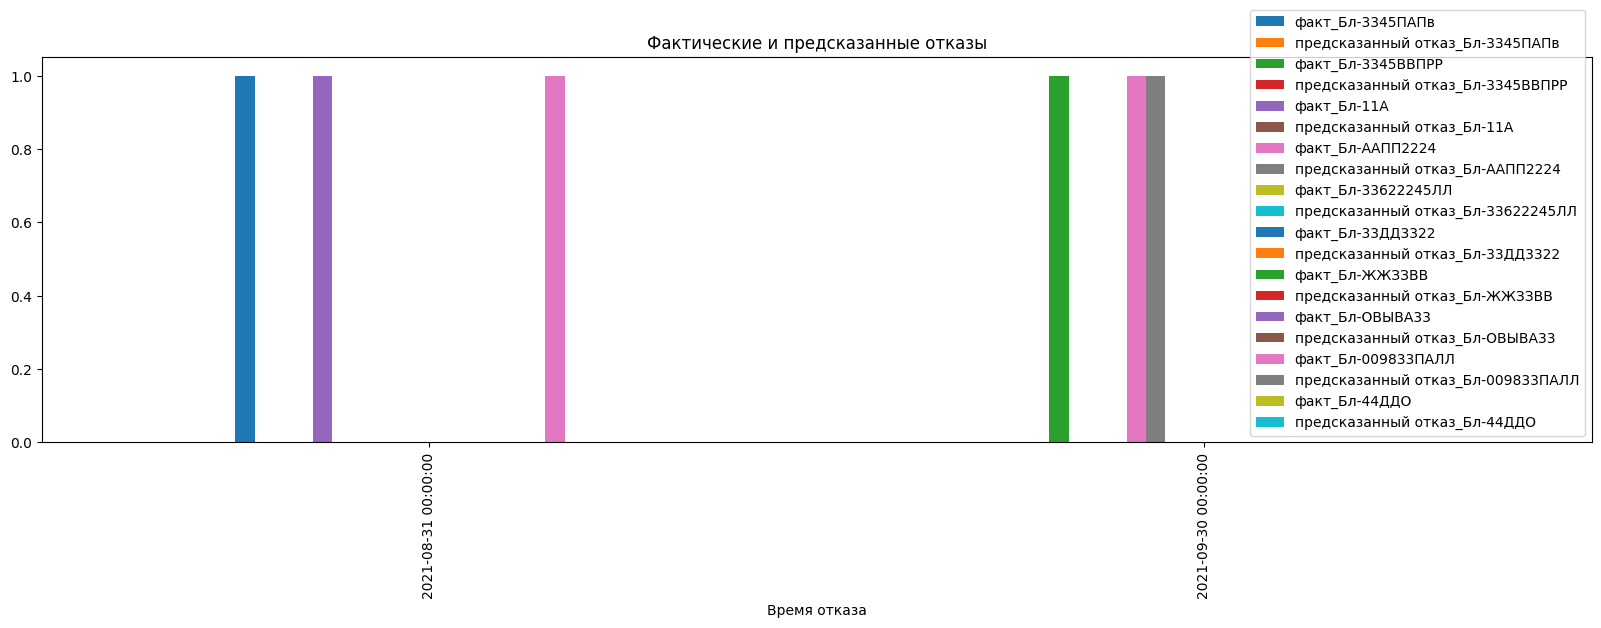

In [86]:
df_predicts_prd = df_predicts_prd.resample('1M').sum()
fig, ax1 = plt.subplots(1, 1, figsize=(20,5))
df_predicts_prd.plot(
    ax= ax1,
    kind= 'bar',
    title='Фактические и предсказанные отказы',
    xlabel='Время отказа'
)
plt.show()